In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from mpsfmachine import Asteroid
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import lightkurve as lk
plt.style.use('seaborn-white')

In [61]:
a = Asteroid.read('../../edr3/pdart-edr3-asteroid777-s10-mtpf.fits', nsubtimes=11)
#a = a[a.flux.sum(axis=(1, 2)) != 0]
a.Col -= 0.75
a.__post_init__()
a._get_prf();

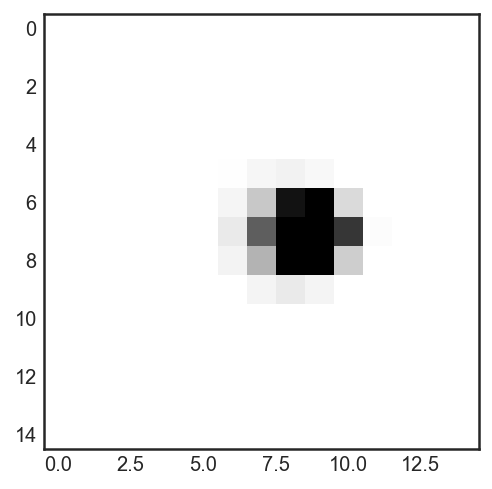

In [62]:
plt.imshow(a.fmodel.reshape(a.shape)[0], vmin=0, vmax=0.05)

In [63]:
a.fmodel.shape

(236025,)

In [64]:
A = a._A_all_flux

Text(0.5, 1.0, 'Average Asteroid Image')

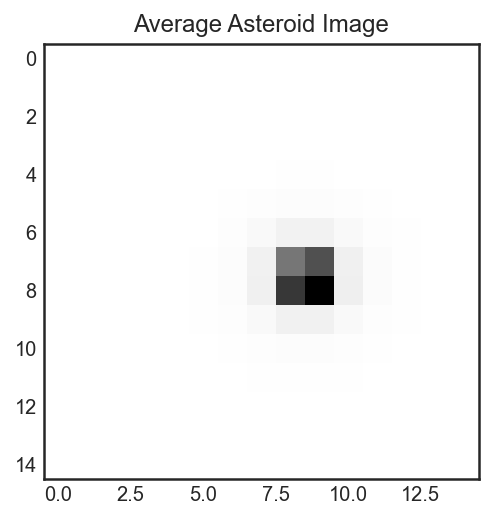

In [65]:
thumb = (np.median(a.flux, axis=0))
thumb -= np.median(thumb)
plt.imshow(thumb)
plt.title("Average Asteroid Image")

In [80]:
# I'm fitting the model here
A = a._A_all_flux
ncomps = A.shape[1]
prior_mu = np.zeros(A.shape[1])
prior_sigma = np.ones( A.shape[1]) * np.inf
prior_sigma[a.shape[0]:a.shape[0]*2] = 10
w = a._solve_linear_model(A, a.flux.ravel(), prior_mu=prior_mu, prior_sigma=prior_sigma)
model = A[:, :a.shape[0]].dot(w[:a.shape[0]]).reshape(a.shape)

[Text(0.5, 1.0, 'Model')]

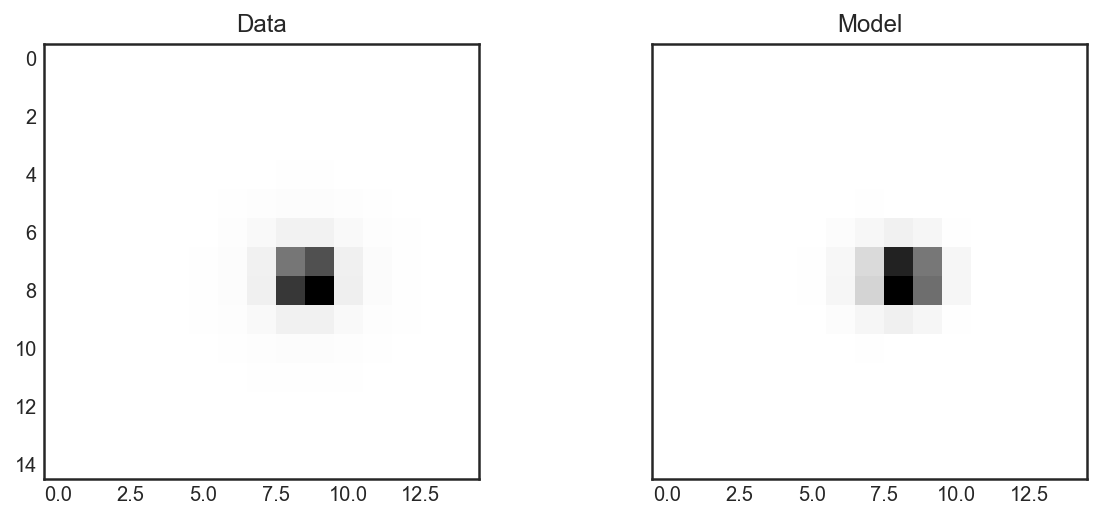

In [97]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
ax[0].imshow(thumb, cmap='Greys')
ax[1].imshow(np.median(model, axis=(0)))
ax[0].set(title='Data')
ax[1].set(title='Model')

Below are the first 10 panels of the model

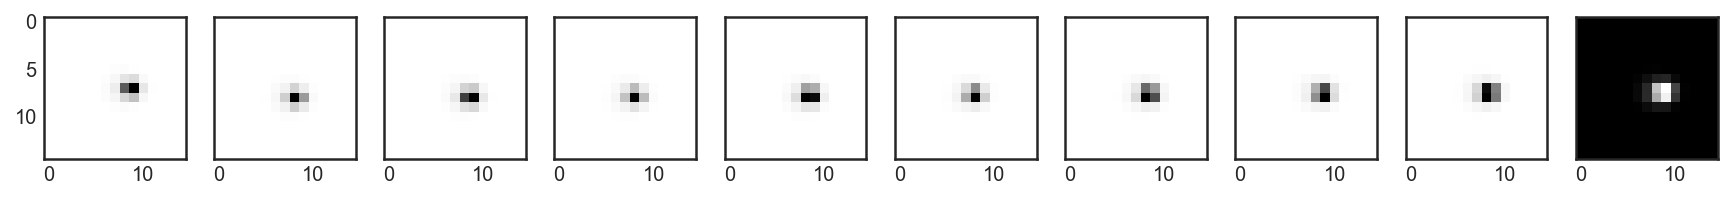

In [82]:
fig, axs = plt.subplots(1, 10, figsize=(15, 1.5), sharex=True, sharey=True)
for idx, ax in enumerate(axs):
    ax.imshow(model[idx])

/Users/ch/Library/Caches/pypoetry/virtualenvs/mpsfmachine-OBUAwnGW-py3.8/lib/python3.8/site-packages/lightkurve/lightcurve.py:212: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  warnings.warn(


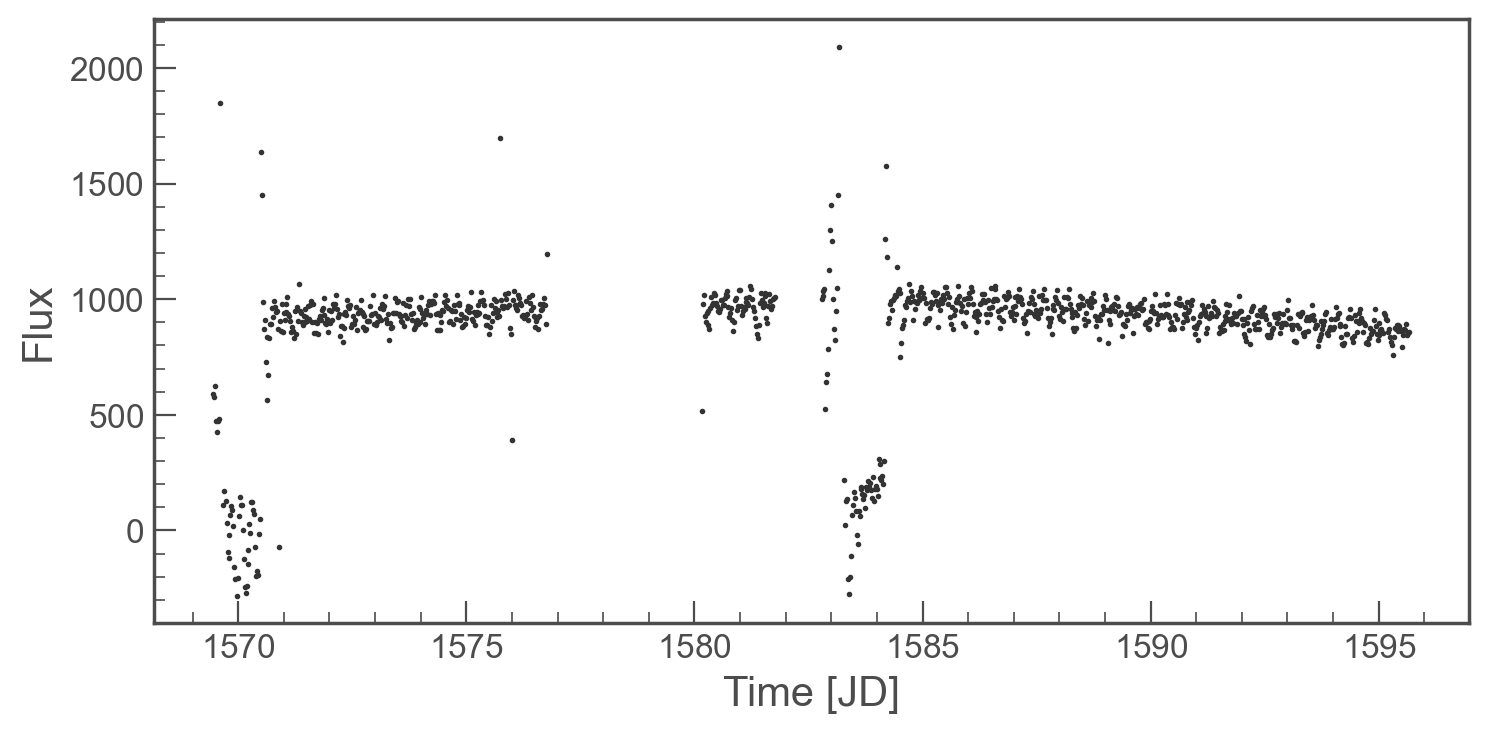

In [83]:
ax = lk.LightCurve(a.time, w[:a.shape[0]]).remove_outliers().scatter(title='Best Fit Light Curve')

/Users/ch/Library/Caches/pypoetry/virtualenvs/mpsfmachine-OBUAwnGW-py3.8/lib/python3.8/site-packages/lightkurve/lightcurve.py:212: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  warnings.warn(


<AxesSubplot:xlabel='Time [JD]', ylabel='Flux'>

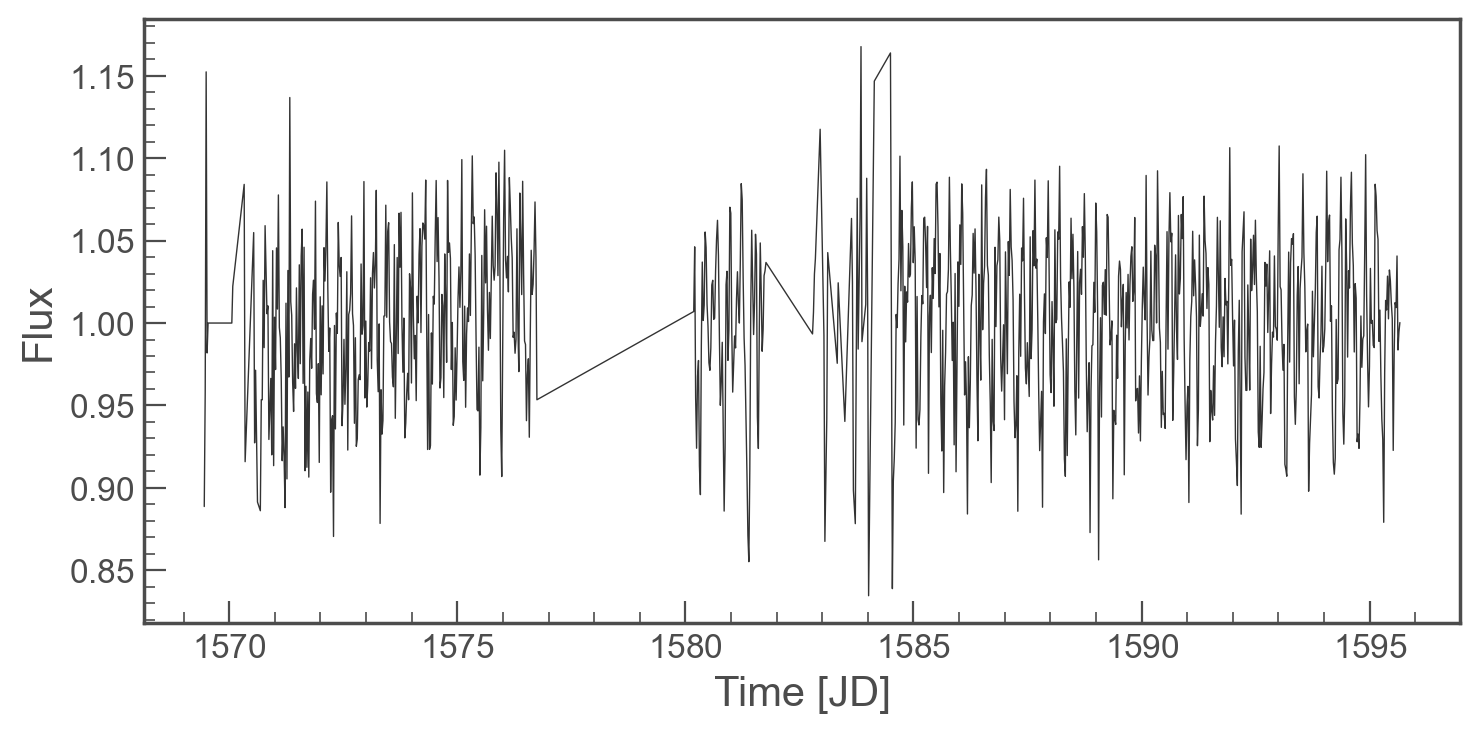

In [84]:
lk.LightCurve(a.time, w[:a.shape[0]]).flatten(301).remove_outliers(sigma=3).plot()

/Users/ch/Library/Caches/pypoetry/virtualenvs/mpsfmachine-OBUAwnGW-py3.8/lib/python3.8/site-packages/lightkurve/lightcurve.py:212: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  warnings.warn(


(0.8, 1.1)

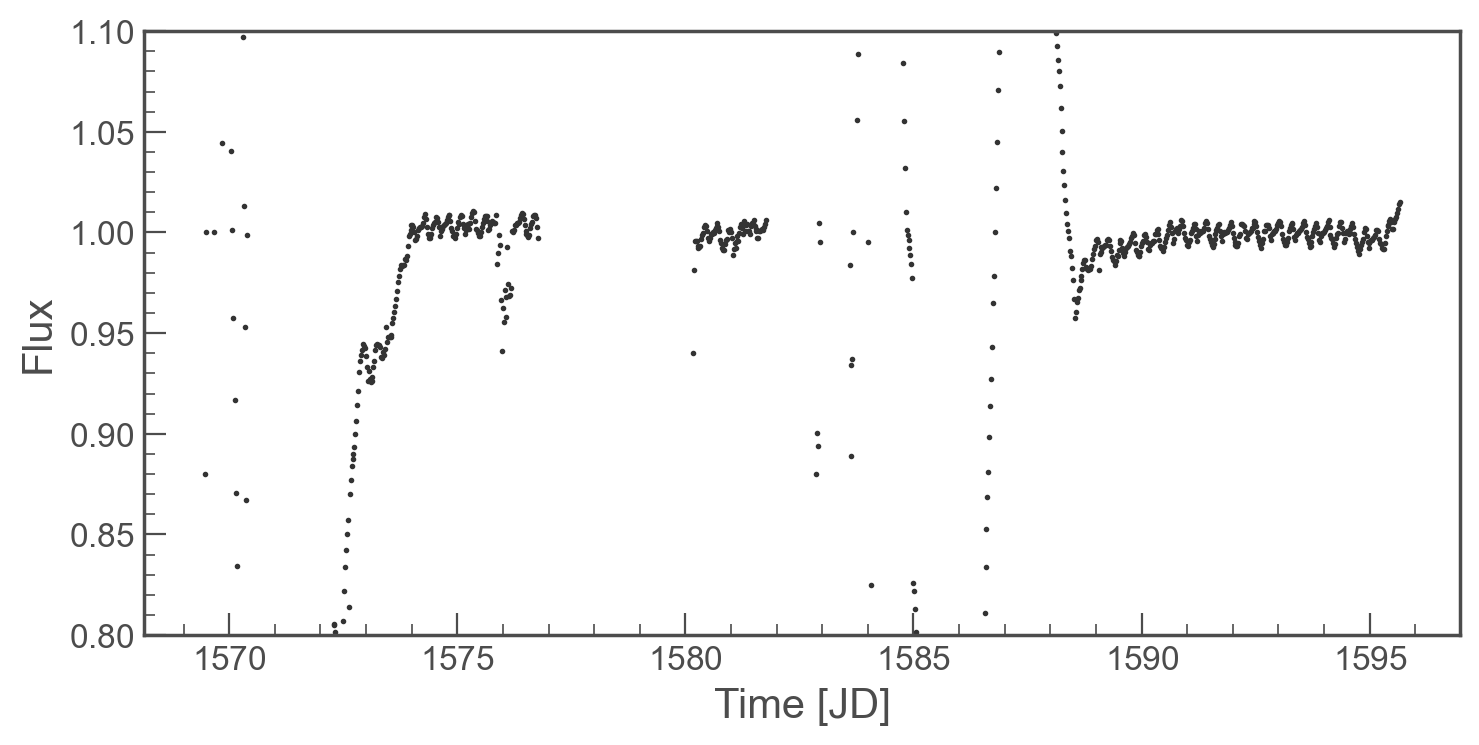

In [85]:
lk.LightCurve(a.time, a.flux[:, thumb > 0.1].sum(axis=1)).flatten(301).remove_outliers(sigma=3).scatter()
plt.ylim(0.8, 1.1)

All that correlated noise is probably due to the fact that the PSF shape isn't large enough yet. We can see in the residuals that we're not counting the motion, I'll add that next!

In [86]:
full_model = A.dot(w).reshape(a.shape)

Still some large residuals, because we're not fitting for the motion of the object, so we're getting less good photometry, I'll add that into the model next!

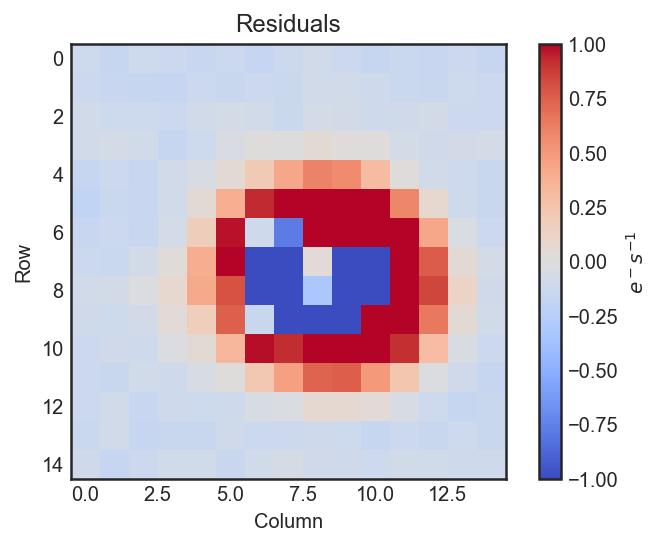

In [87]:
fig, ax = plt.subplots()
im = ax.imshow(np.median(a.flux - full_model, axis=0), vmin=-1, vmax=1, cmap='coolwarm')
cbar = plt.colorbar(im, ax=ax)
ax.set(xlabel='Column', ylabel='Row', title='Residuals')
cbar.set_label("$e^-s^{-1}$")

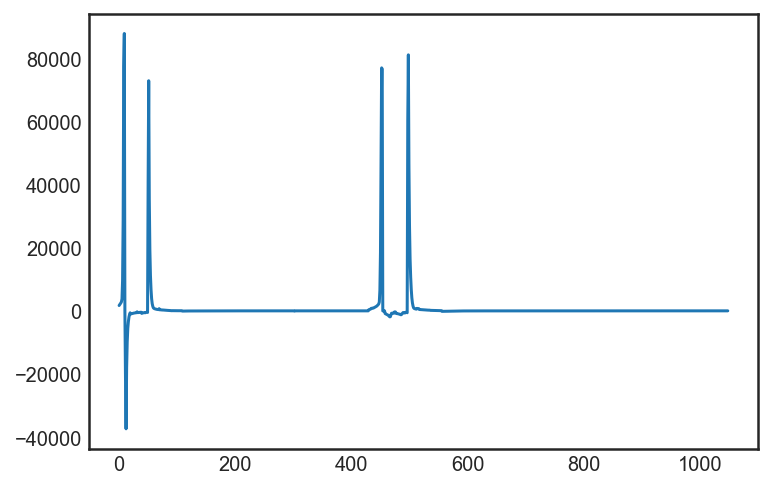

In [88]:
plt.plot(w[a.shape[0]:a.shape[0]*2])